# hitmen - Engineered features
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* Feb 25, 2022

## Hypothesis
The goal of this notebook is to compare the results of the model with the model using standard StellarAlgo features with the engineered retention model features.

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [1]:
import getpass
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from pycaret.classification import *

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
# connect to SQL Server.
SERVER = '34.206.73.189'  
DATABASE = 'datascience' 
USERNAME = 'nrad' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

In [3]:
lkupclientid = 37 # hitmen
cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrWHL].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"])

CNXN.commit()
cursor.close()

df.shape

(5713, 54)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5713 entries, 0 to 5712
Data columns (total 54 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   lkupClientId            5713 non-null   int64  
 1   dimCustomerMasterId     5713 non-null   int64  
 2   customerNumber          5713 non-null   object 
 3   year                    5713 non-null   int64  
 4   productGrouping         5713 non-null   object 
 5   totalSpent              5713 non-null   float64
 6   recentDate              5713 non-null   object 
 7   attendancePercent       5713 non-null   float64
 8   renewedBeforeDays       5713 non-null   int64  
 9   isBuyer                 5713 non-null   object 
 10  source_tenure           5713 non-null   int64  
 11  tenure                  5713 non-null   int64  
 12  distToVenue             5713 non-null   float64
 13  totalGames              5713 non-null   int64  
 14  recency                 5713 non-null   

### We should specify the features used in our model:

In [5]:
# choose the features for the stellar base retention model
features = ["year",
            "isNextYear_Buyer",
            "productGrouping",
            "dimCustomerMasterId",
            "renewedBeforeDays",
        "tenure",
        "source_tenure",
        "totalGames",
        "missed_games_1",
        "missed_games_2",
        "missed_games_over_2",
        "is_Lockdown",
        "NumberofGamesPerSeason"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2019]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (4196, 13)
Unseen Data For Predictions: (740, 13)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [6]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=["dimCustomerMasterId","productGrouping","year"],
    silent=True,
    verbose=False,
    numeric_features=[
               "renewedBeforeDays",
        "tenure",
        "source_tenure",
        "totalGames",
        "missed_games_1",
        "missed_games_2",
        "missed_games_over_2",
        "is_Lockdown",
        "NumberofGamesPerSeason"
    ]
);

In [7]:
model_matrix = compare_models(
    fold=10,
    include=["lr", "xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.8766,0.9118,0.9419,0.8643,0.9014,0.7374,0.7426,0.3120
lr,Logistic Regression,0.7922,0.8396,0.8328,0.8228,0.8275,0.5662,0.5670,0.3010


In [8]:
best_model = create_model(model_matrix)
final_model = finalize_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8796,0.9127,0.9439,0.8670,0.9038,0.7435,0.7484
1,0.8627,0.9052,0.9112,0.8667,0.8884,0.7105,0.7120
2,0.8739,0.9115,0.9299,0.8690,0.8984,0.7329,0.7358
3,0.8908,0.9139,0.9673,0.8661,0.9139,0.7657,0.7745
4,0.8936,0.9182,0.9626,0.8729,0.9156,0.7725,0.7793
5,0.8908,0.9184,0.9390,0.8850,0.9112,0.7697,0.7719
6,0.8596,0.8997,0.9437,0.8410,0.8894,0.6988,0.7075
7,0.8904,0.9387,0.9531,0.8750,0.9124,0.7670,0.7720
8,0.8792,0.8986,0.9484,0.8632,0.9038,0.7425,0.7484
9,0.8455,0.9010,0.9202,0.8376,0.8770,0.6706,0.6760


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

### Let's load in our 2021 season data and get retention scores using the model:

In [9]:
df_inference = df.loc[df["year"] >= 2021]
df_inference = df_inference.fillna(0)
df_inference.shape

(777, 54)

In [10]:
new_predictions = predict_model(final_model, data=df_inference, raw_score=True)
new_predictions.head()

,lkupClientId,dimCustomerMasterId,customerNumber,year,productGrouping,totalSpent,recentDate,attendancePercent,renewedBeforeDays,isBuyer,...,education,urbanicity,credits_after_refund,is_Lockdown,NumberofGamesPerSeason,CNTPostponedGames,isNextYear_Buyer,Label,Score_0,Score_1
4936,37,288,117436,2021,Full Season,420.75,2022-02-27,0.760000,48,TRUE,...,0,0,0.0,1,34,0,0,0,0.9989,0.0011
4937,37,371,9707257,2021,Full Season,706.86,2022-02-20,0.600000,10,TRUE,...,0,0,0.0,1,34,0,0,0,0.9996,0.0004
4938,37,1685,679381,2021,Full Season,776.28,2022-02-27,0.746269,48,TRUE,...,0,0,0.0,1,34,0,0,0,0.9989,0.0011
4939,37,1995,8603944,2021,Full Season,900.24,2022-02-27,0.480000,48,TRUE,...,0,0,0.0,1,34,0,0,0,0.9986,0.0014
4940,37,2143,145431,2021,Full Season,0.00,2022-01-30,0.380000,17,FALSE,...,0,0,0.0,1,34,0,0,0,0.9983,0.0017


In [11]:
new_predictions["Label"].value_counts()

0    719
1     58
Name: Label, dtype: int64

In [12]:
new_predictions["Score_1"].value_counts(bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

(-0.001, 0.2]    690
(0.6, 0.8]        32
(0.4, 0.6]        20
(0.8, 1.0]        20
(0.2, 0.4]        15
Name: Score_1, dtype: int64

array([[<AxesSubplot:title={'center':'Score_1'}>]], dtype=object)

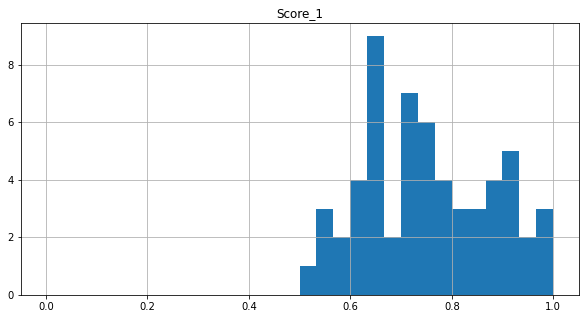

In [13]:
new_predictions[new_predictions["Label"]==1][["Score_1"]].hist(bins=30, figsize=(10,5), range=[0,1])

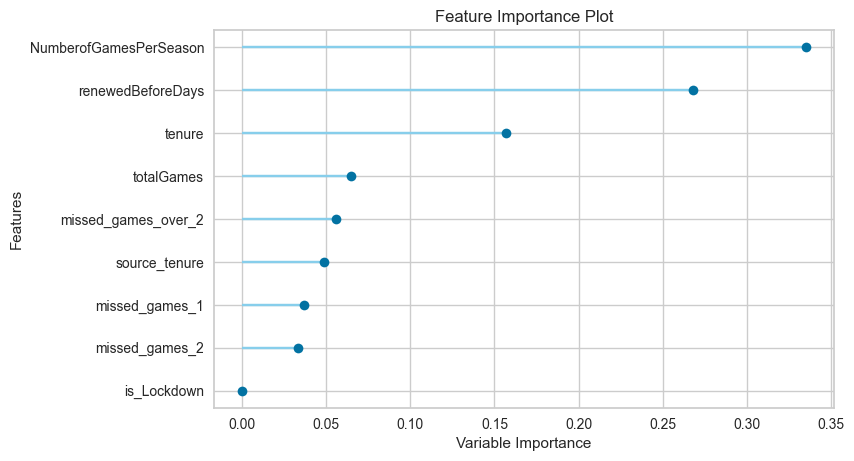

In [14]:
plot_model(best_model, plot='feature')

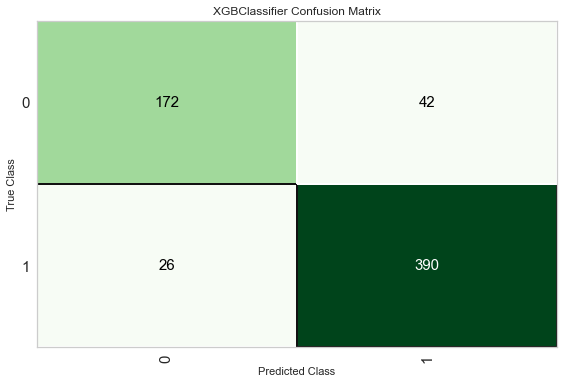

In [15]:
plot_model(best_model, plot='confusion_matrix')

## Observations
Here you can document some ideas on the results from above


## Conclusions
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?